In [1]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)


data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [7]:
train_portion = int(len(data) * 0.85)    #1
test_portion = int(len(data) * 0.1)            #2
val_portion = len(data) - train_portion - test_portion    #3

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [8]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:         #1
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)   #1
    inputs_lst = []
    for item in batch:     #2
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])    #3
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)     #4
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [12]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])     #1
        targets = torch.tensor(padded[1:])    #2
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [13]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (                               #1
            new_item + [pad_token_id] *          #1
            (batch_max_length - len(new_item))   #1
        )
        inputs = torch.tensor(padded[:-1])      #2
        targets = torch.tensor(padded[1:])     #3
        mask = targets == pad_token_id              #4
        indices = torch.nonzero(mask).squeeze()     #4
        if indices.numel() > 1:                     #4
            targets[indices[1:]] = ignore_index     #4
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]       #5
            targets = targets[:allowed_max_length]     #5
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [14]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [15]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],     #1
     [-0.5, 1.5]]      #2
)
targets_1 = torch.tensor([0, 1]) # Correct token indices to generate
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [16]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]      #1
)
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [17]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():   #1
#     device = torch.device("mps")"      
print("Device:", device)

Device: cuda


In [19]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [20]:
from torch.utils.data import DataLoader

num_workers = 0      #1
batch_size = 2

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [21]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([2, 61]) torch.Size([2, 61])
torch.Size([2, 55]) torch.Size([2, 55])
torch.Size([2, 58]) torch.Size([2, 58])
torch.Size([2, 58]) torch.Size([2, 58])
torch.Size([2, 62]) torch.Size([2, 62])
torch.Size([2, 47]) torch.Size([2, 47])
torch.Size([2, 76]) torch.Size([2, 76])
torch.Size([2, 54]) torch.Size([2, 54])
torch.Size([2, 67]) torch.Size([2, 67])
torch.Size([2, 73]) torch.Size([2, 73])
torch.Size([2, 50]) torch.Size([2, 50])
torch.Size([2, 55]) torch.Size([2, 55])
torch.Size([2, 68]) torch.Size([2, 68])
torch.Size([2, 51]) torch.Size([2, 51])
torch.Size([2, 61]) torch.Size([2, 61])
torch.Size([2, 68]) torch.Size([2, 68])
torch.Size([2, 65]) torch.Size([2, 65])
torch.Size([2, 53]) torch.Size([2, 53])
torch.Size([2, 54]) torch.Size([2, 54])
torch.Size([2, 57]) torch.Size([2, 57])
torch.Size([2, 57]) torch.Size([2, 57])
torch.Size([2, 72]) torch.Size([2, 72])
torch.Size([2, 60]) torch.Size([2, 60])
torch.Size([2, 59]) torch.Size([2, 59])
torch.Size([2, 58]) torch.

In [22]:
inputs.device, targets.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [17]:
from gpt_download import download_and_load_gpt2
from chap4 import GPTModel, generate_text_simple
from chap5 import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="/work/tmp/gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-03-30 23:07:40.111869: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 23:07:40.120246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743376060.129922    1103 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743376060.132811    1103 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743376060.140055    1103 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

File already exists and is up-to-date: /work/tmp/gpt2/124M/checkpoint
File already exists and is up-to-date: /work/tmp/gpt2/124M/encoder.json
File already exists and is up-to-date: /work/tmp/gpt2/124M/hparams.json
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: /work/tmp/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: /work/tmp/gpt2/124M/vocab.bpe


In [24]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [25]:
%load_ext autoreload
%autoreload 2
from chap5 import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [26]:
generated_text

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Instruction:\n\nConvert the active"

In [27]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [28]:
%load_ext autoreload
%autoreload 2
from chap5 import calc_loss_loader, train_model_simple, evaluate_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.089017629623413
Validation loss: 4.00831356048584


In [30]:
import time

start_time = time.time()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.180, Val loss 3.139
Ep 1 (Step 000005): Train loss 1.527, Val loss 1.800
Ep 1 (Step 000010): Train loss 1.223, Val loss 1.315
Ep 1 (Step 000015): Train loss 1.004, Val loss 1.215
Ep 1 (Step 000020): Train loss 1.025, Val loss 1.187
Ep 1 (Step 000025): Train loss 0.914, Val loss 1.147
Ep 1 (Step 000030): Train loss 1.059, Val loss 1.144
Ep 1 (Step 000035): Train loss 1.131, Val loss 1.129
Ep 1 (Step 000040): Train loss 0.858, Val loss 1.091
Ep 1 (Step 000045): Train loss 1.063, Val loss 1.072
Ep 1 (Step 000050): Train loss 0.899, Val loss 1.062
Ep 1 (Step 000055): Train loss 1.137, Val loss 1.063
Ep 1 (Step 000060): Train loss 1.019, Val loss 1.047
Ep 1 (Step 000065): Train loss 0.657, Val loss 1.023
Ep 1 (Step 000070): Train loss 0.694, Val loss 1.028
Ep 1 (Step 000075): Train loss 0.986, Val loss 1.018
Ep 1 (Step 000080): Train loss 0.705, Val loss 1.012
Ep 1 (Step 000085): Train loss 0.780, Val loss 1.010
Ep 1 (Step 000090): Train loss 0.738, Val loss

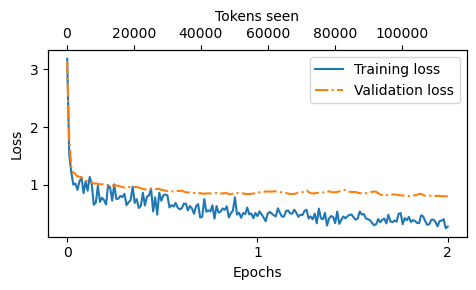

In [31]:
from chap5 import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [32]:
torch.manual_seed(123)

for entry in test_data[:3]:      #1
    input_text = format_input(entry)
    token_ids = generate(               #2
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is cirrus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Pre

In [33]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)         #1

100%|██████████| 110/110 [02:50<00:00,  1.55s/it]


In [34]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [35]:
import re

file_name = f"/work/tmp/gpt2/{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"      #1
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as /work/tmp/gpt2/gpt2-small124M-sft.pth


# Test framework

### The follow code bellow will not work properly from inside a container.

In [5]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "Ollama not running. Launch ollama before proceeding."
)
print("Ollama running:", check_if_running("ollama"))

RuntimeError: Ollama not running. Launch ollama before proceeding.

In [6]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"
with open(file_path, "r") as file:
    test_data = json.load(file)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )


    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

In [11]:
import urllib.request

def query_model(prompt, model="gemma3:1b", url="http://192.168.0.123:11434/api/chat"):
    data = {             #1
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {         #2
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    payload = json.dumps(data).encode("utf-8")    #3
    request = urllib.request.Request(                       #4
        url,                                                #4
        data=payload,                                       #4
        method="POST"                                       #4
    ) #4

    request.add_header("Content-Type", "application/json")   #4

    response_data = ""
    with urllib.request.urlopen(request) as response:   #5
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

In [12]:
result = query_model("What do Llamas eat?", 'gemma3:1b')
print(result)

Llamas are surprisingly versatile herbivores and have a pretty varied diet! Here's a breakdown of what they typically eat:

**1. The Majority - Grass & Forage:**

* **Grass:** This is their primary food source, especially in the western United States and parts of South America. They'll graze on a wide variety of grasses.
* **Forage:** They love foraged plants, including:
    * **Acorns:** A staple in many llama habitats.
    * **Shrubs & Bushes:** They'll nibble on various shrubs and bushes.
    * **Wild Berries & Fruits:** They'll eat wild berries and fruits when available.
    * **Leaves & Twigs:** They'll consume leaves and twigs, especially in the spring and summer.


**2. Supplementation - What They Eat When Available:**

* **Hay:** Llamas need hay to supplement their diet, especially during the winter months when grass is scarce.
* **Pasture:** They graze on pasture, supplementing their diet with fresh vegetation.
* **Vegetables:**  They'll eat vegetables like:
    * **Carrots:**

In [13]:
def generate_model_scores(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."   #1
        )
        score = query_model(prompt)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [14]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   9%|▉         | 10/110 [00:05<01:07,  1.48it/s]

Could not convert score: Prime numbers: 11, 19
Composite numbers: 18


Scoring entries:  15%|█▍        | 16/110 [00:09<00:56,  1.66it/s]

Could not convert score: Plants: Solid
Animals: 0



Scoring entries:  18%|█▊        | 20/110 [00:12<01:34,  1.05s/it]

Could not convert score: Never have I ever seen a sunset like this without a warm cup of tea.
Score: 95



Scoring entries:  21%|██        | 23/110 [00:14<01:09,  1.25it/s]

Could not convert score: The opposite of 'deep' is 'shallow'. 100



Scoring entries:  41%|████      | 45/110 [00:26<00:35,  1.81it/s]

Could not convert score: 95

Score: 95



Scoring entries:  43%|████▎     | 47/110 [00:27<00:39,  1.58it/s]

Could not convert score: Could you tell me the meeting time?

Score: 100



Scoring entries:  55%|█████▌    | 61/110 [00:35<00:25,  1.93it/s]

Could not convert score: young



Scoring entries:  61%|██████    | 67/110 [00:38<00:26,  1.64it/s]

Could not convert score: Did the dog chase the cat?
Score: 100



Scoring entries:  78%|███████▊  | 86/110 [00:49<00:15,  1.55it/s]

Could not convert score: The professor attempted to elucidate the complex topic for his students. – 95



Scoring entries:  83%|████████▎ | 91/110 [00:53<00:12,  1.47it/s]

Could not convert score: The food was delicious.



Scoring entries:  84%|████████▎ | 92/110 [00:54<00:13,  1.31it/s]

Could not convert score: The opposite of 'lazy' is 'diligent'.
Score: 100



Scoring entries:  85%|████████▍ | 93/110 [00:55<00:14,  1.19it/s]

Could not convert score: 1. Vitamin A
2. Vitamin C
3. Vitamin D
Score: 100



Scoring entries: 100%|██████████| 110/110 [01:06<00:00,  1.66it/s]

Could not convert score: 32.07

Number of scores: 97 of 110
Average score: 82.47



# Using our model

In [18]:
import re

file_name = f"/work/tmp/gpt2/{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"  
file_name

'/work/tmp/gpt2/gpt2-small124M-sft.pth'

In [21]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():   #1
#     device = torch.device("mps")"      
print("Device:", device)

Device: cuda


In [31]:
model_state_dict = torch.load(file_name, map_location=device)
model.load_state_dict(model_state_dict)
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='tanh')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Li

In [82]:
import urllib.request
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
from chap5 import text_to_token_ids, token_ids_to_text

def query_model_our_model(prompt):
    model.eval()
    encoded = text_to_token_ids(prompt, tokenizer).to(device)
    logits = model(encoded)
    idx_next = torch.argmax(logits, dim=-1, keepdim=True).squeeze(0).transpose(0,1)
    response_data = token_ids_to_text(idx_next, tokenizer).replace('<|endoftext|>', '')
    return response_data

In [83]:
query_model_our_model('Could you tell me the meeting time?')

' is please me what formula was of\n'

In [84]:
result = query_model_our_model("What do Llamas eat?")
print(result)

 is youazyas mean?


In [85]:
def generate_model_scores_our_model(json_data, json_key):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."   #1
        )
        score = query_model_our_model(prompt)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [86]:
scores = generate_model_scores_our_model(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   2%|▏         | 2/110 [00:00<00:14,  7.40it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatrite the sentence using a metaphorile.

### Input:
She wind is very fast.

 the response:The car is as fast as a.
: correct..The car is as fast as a bullet.
 the bullet of 1 to 100. positive 100 is very normal possible,
ing the appropriate result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is of compound is formed seen with the??


 answers:The type of cloud is associated with thunderstorms is aulusonimbus.
: correct correctly.The type of cloud typically associated with thunderstorms is cumrus.`. a 10 of 1 to 10. positive 1 is normal normal,.
ing a model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that ap

Scoring entries:   5%|▌         | 6/110 [00:00<00:07, 13.53it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical formula for the?


 the:0 periodic symbol for chlorine is CH.
: correct correctly appropriatelyCl periodic symbol for chlorine is C.`. a 10 of 1 to 9. positive 0 is neutral periodic,,
ing a model value 10 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the spellinguation in the sentence.

### Input:
The raining to go to.


 the:Where time sentence is be: 'It's time to go home.'

: corrected:.The corrected sentence should be: 'It's time to go home.' the scale of 1 to 10. positive 1 is perfect normal.. to the correct result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the requ

Scoring entries:   9%|▉         | 10/110 [00:00<00:06, 16.28it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the main spelling of 'Theieve'
 'recceive.'

 ' spelling:Rec correct spelling is 'recceive'.
: request::The model spelling is 'reieve'.` a scale of 1 to 10. positive 1 is perfect normal,, to the spelling result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What a new that the word 'darrowalgia'.


 the:Theostalgia is over the.' she went at the window store'.
: correct`.The model photos was 'wostalgia' was ' synonym for 'wear'.
 July syn of 1 to 10. positive a is very past,.ing the correct result 10 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the fol

Scoring entries:  13%|█▎        | 14/110 [00:00<00:05, 17.44it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical of 'smallonder'?

 ' the:Below opposite of 'wet' is 'dry'.

: correct correctly.0 model of 'dryet' is 'dry'.` 12 model of 1 to 10. positive a is warm normal,, to ' model result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the main of sentence.

### Input:
The you know your homework?


 the:Did type of sentence is 'ative.
: correct..The type of sentence is interrog.
 the dependent of 1 to 10. positive 100 is interrog most..ing the model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical formula for iron?


 the:C2' c

Scoring entries:  16%|█▋        | 18/110 [00:01<00:05, 17.09it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the following statement: either food or liquid, or gas.

### Input:
Iceury
 Iron, iron

 ' the:Plury` Solid'
xygen - Solid
Pl - Solid
 Input: given accurately.Plants - Mercury,Anim: Oxy
Oals: Squirrel model table of solid to 10 from ' is solid solid
: the model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatvert the lit to meters.


 the:3 kilometers is 3000 meters.

: correct correct.3 kilometers is 3000 meters'.
 a scale of 0 to 100. positive 0 is normal square,,
 with a correct result 3 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatvert the given 

Scoring entries:  20%|██        | 22/110 [00:01<00:06, 14.55it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence that follows the pattern: 'The miss felt seen been_____" it_____."

 " the:I have I ever without without   without

: correct correctly.The have I ever traveled a  a a.' had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had had ha

Scoring entries:  24%|██▎       | 26/110 [00:01<00:05, 16.42it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatategorize the given numbers of animals.

### Input:
Bearark
 Elephant, Elephant

 Elephant the:Here, Shark, Dolphin`
inerals: Dolphin
 Shark: given::Fishals: DolphinFals: Dolphin the scale of 1 to 10 from ' is perfect best..: the model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatlate 'Where' into French.

 ' Spanish:Here Spanish translation for 'library' is 'liblioteca'.

: translation..The Spanish word of 'library' is 'b b estños'.ñños'. Julyria of 1 to 10. 1 1 is neutral best score. to a model result 3 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Wha

Scoring entries:  27%|██▋       | 30/110 [00:01<00:04, 17.14it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatine the term 'quantetic'.'.

 ` any:Hereetic energy' the total that is object is that to its being,
: correct `.0 model 'kinetic energy' is ' type of energy that is generated by a process's movement body. is typically expressed in terms of a type of electromagnetic field. the scale of 0 to 10. positive 0 is neutral mass,.ing the model result 10 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical of 'small'?

 ' the:Below opposite of 'hot' is 'cold'.

: correct correctly.0 model of 'hot' is 'cold'.` 12 10 of 0 to 10. positive 1 is neutral normal,,
 to ' model result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response 

Scoring entries:  31%|███       | 34/110 [00:02<00:04, 17.90it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatrite the sentence sentence to use the active with with

### Input:
She's hot cold of cake.
 everyone the:It's a tasty to
rs cake`.Easy
###'s a cake of cake. the piece of 1 to 10. positive 1 is perfect smallest,.ing a appropriate result 3 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the types types of flowers



 the:Ve. Brorot'2. Broccoli
3. Broucumber
4. Tomato
5. Basilach
 corrected: correct::1. Carccoli
6. Carccoli3. Tomatoccoli4. Tomatoccoli5. Spinccoli the scale of 1 to 10 100 100 is perfect smallest
.ing the model result 5.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### In

Scoring entries:  35%|███▍      | 38/110 [00:02<00:03, 18.24it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical tense of 'buildular

 ' me:Here past tense of 'sing' is 'pastang'. corrected: correct correctly.The past tense of 'sing' is 's.' the continuous of 1 to 10. positive ' is perfect past.. to ' correct ' 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical formula for the??


 the:0 molecular formula for carbon dioxide is CH2.

: correct correctly.Correct molecular formula for carbon dioxide is CH3. a 10 of 1 to 9. where 1 is neutral normal,.
: a model result 10.

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatvert the sentence to use vo

Scoring entries:  38%|███▊      | 42/110 [00:02<00:03, 17.48it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatain the a synogram is.

 ` any:He sonnet is a son-digit cell. a rhy rhythmme scheme. a. typically ' in the.ic pentateter.

: correct::The sonnet is a 12 for measures the length of a child's body. the base of the or her feet to the base of his or her legs's a 7 of 1 to 10. 1 100 is perfect smallest,.
 to the model result 0:
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence that the word 'dovative'.

 ` the:The project is developing for innovative innovative ideas and
: correct a.The company was inspired by its company of the team manager. the computer of 1 to 10. positive 100 is innovative highest,.
ing the sentence result 10 100

Could not convert score:  is correct sentencehello 

Scoring entries:  42%|████▏     | 46/110 [00:02<00:03, 17.94it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence-tense verb that follows a person who.

 ' the:Sheaughter at` corrected: sentence a.C past-tense verb that describes a person laughing is 'Curious'.` 12ria of 1 to 10. positive a is very normal,,ing the correct result 5:
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence that the word 'dcend'.

 ` the:Trans room was of the voice was a lasting impression on
rs sentence a.Trans was very intelligent and helps helps others in need.` the scale of 1 to 10. positive 100 is very most,.
 with the sentence result 10 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Inst

Scoring entries:  45%|████▌     | 50/110 [00:03<00:03, 18.35it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatategorize the given items into either command. statement command, or a actionclamation.

### Input:
I is cute day!

 '::Whatqu: corrected: given a.Beaut model wasThe a beautiful day!"`. a statement.
 the question of 1 to 10. positive 1 is perfect perfect,,ing the given question 100 1
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical of 'small'?

 ' the:Below opposite of 'rich' is 'poor'.

: correct correctly.0 model of 'poor' is 'poor'.` average scale of 0 to 10. 100 ' is ' normal,, to ' model result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What t

Scoring entries:  49%|████▉     | 54/110 [00:03<00:03, 18.58it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the given sentence into a command. 'should"

### Input:
She can't me..

 ' the:Could you help me tomorrow?
: correct..Could you help me tomorrow?`.
 the scale of 1 to 10. positive 100 is neutral normal score,
ing ' correct result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the following statement: hammer, car, cat.

 ' the:Animicle: Horse,Mants: Rose
Animals: Tiger corrected: correct..Animals: BicycleCorrectants: RoseCorrectals: RoseCorrectals: Bat the bicycle of 0 to 10 100 100 is perfect normal..: the model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### In

Scoring entries:  53%|█████▎    | 58/110 [00:03<00:02, 17.73it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatain the process function of the human nervous.


 any:Here primary function of the human heart is to supply blood to the body and to oxygen and nutrients to the, to toxins dioxide from water substances from It
: correct..The primary function of the human heart is to pump blood and the body, to remove blood to the tissues and to remove heat signals from the body.` the continuous of 1 to 10. positive 1 is normal normal,.ing the model result 10 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatrite the sentence sentence to use past tense.

### Input:
The is very a book. by the past's


 the:He is be reading a novel inspired by his grandmother.' corrected: correct sentence.He will reading a novel 

Scoring entries:  56%|█████▋    | 62/110 [00:03<00:02, 18.18it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatategorize the given items into either formal or fictional.prov.

### Input:
Theocolate is delicious best thing in

 ' response:Theuchion isbased'
: sentence a.C best isThe best dessert is chocolate."`. factual on fact. the factual of 1 to 3. positive 100 is factual best,,ing the correct result 3.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the antonym of 'begin'?

 ` the:old'

 ` correct correctly.old. old antonym of 'old'. 'old is
 line model of 0 to 10. 100 ' is old past,,
ing ` response result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatide a synonym

Scoring entries:  60%|██████    | 66/110 [00:03<00:02, 18.43it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical form of 'begin'?

 ' the:Here plural form of 'child' is 'child'.

: given correctly.Here plural form of 'child' is 'children'.` line sem of 1 to 10. positive 1 is positive smallest,, to ' model result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the antonym of 'beginacent'?

 ` the:Here antonym of 'complicated' is 'diff'.

: correct correctly.An antonym of 'simpleicated' is 'simpleicult'. 12 success of 1 to 10. 100 100 is very normal,. to ' model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the types of water.

 ' the:1 three

Scoring entries:  64%|██████▎   | 70/110 [00:04<00:02, 18.54it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the following sentence into two declarative sentences: 'The cat was very.' the.'

 '::The movie was long but Interesting was interesting but
: movie..The movie was interesting. interesting.' the dependent of 1 to 10. 100 1 is best longest score.ing ' correct result 5 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the following statement: either, base, or salt.

### Input:
Ciqu juice
 waterap, Honey

 ' answers:Cid: Lemon juice
Base: Soap
Butral: Base Base: correct correct.Ac model as in the given sentence are acid, base, and neutral. the scale of 0 to 10. positive a is neutral normal..ing the model form 100.
Could not convert score:  is correct sentencehello is an instruction that de

Scoring entries:  67%|██████▋   | 74/110 [00:04<00:01, 18.08it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence that the word 'dcend'.

 ` the:Trans voice at the hotel was very and like only a few of days.'
: sentence sentence.He was a active and helps helps others in need. the scale of 1 to 10. positive 100 is very most,.
 with the sentence result 10 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatlate 'Where am tired' into Japanese.

 ' the:I Italian translation of 'I am lost' is 'Il ao ��' (Cal the). or 'Mi pio pero' (if female).

: correct..Here Italian model of 'I am lost' is 'Miaños a� la vita pi'. theria of 1 to 10. 100 1 is perfect normal translation,ing a given result 100:
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a resp

Scoring entries:  71%|███████   | 78/110 [00:04<00:01, 17.97it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatlate 'Where you help a tea?' into French.

 's:Jeorerto levous suoir-ux'éux'.'. corrected: correct..P model model of 'Can I have some water?' is 'P' water? plus proche?`. theusc of 1 to 10. 1 1 is neutral normal score.ing a correct result 100:
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What a newile using the word 'dke as snow


 the:The cold are as cold as ice'.
: correct`.Her simile with a sim one fuzzy blanket chilly thing. a hot of 1 to 10. positive 1 is perfect normal,. with the correct result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the followin

Scoring entries:  75%|███████▍  | 82/110 [00:04<00:01, 18.26it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemicalviation for 'begin of Science Administration'?


 the:Here abbreviation for 'Master of Business Administration' is '.

: correct correctly.M modelviation for 'Master of Business Administration' is MBABAE
 line computer of 1 to 10. 100 a is perfect best,,ing ' model result 5 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatvert the given sentence from decimal toals to 8.

 X the:I Roman ' is Roman numerals is 8.' corrected: correct::The number numerals are ' given number are 9.` the scale of 1 to 9. 100 ' is negative normal,. to the correct ' 9 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately compl

Scoring entries:  78%|███████▊  | 86/110 [00:05<00:01, 18.12it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatrite the sentence sentence to use the activeés with

### Input:
She is very fast as a cucumber.


 the:He was as cool as
: sentence..He was as cool as a cucumber. the hot of 1 to 10. positive 100 is neutral normal..
ing the correct result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the main subject in the sentence.

### Input:
The main barked loudly.

 the the:The main verb in the sentence is 'barked'.

: sentence:.The main verb in the sentence is 'barked'.`. a dependent of 1 to 10. positive 100 is neutral normal..ing the model result 3 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes t

Scoring entries:  82%|████████▏ | 90/110 [00:05<00:01, 14.70it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical for the the hours?


??Here formula for calculating work done is (/ (/ volume.'

: correct..The formula for calculating work done is work1 × distance1/2) * distance1/2) * distance1/2) * distance1/2) + distance1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + (1/2) + ( the computer of 0 to 10. positive 100 is positive normal..
 to the correct result of.

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical formula for sodiumium chloriderate?

Scoring entries:  85%|████████▌ | 94/110 [00:05<00:00, 16.50it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical of 'smallazy'?

 ` answers:Here opposite of 'lazy' is 'cheiligent'.

: correct correctly.The model of 'dazy' is 'dap'.` a scale of 1 to 10. positive a is very smallest,, to ' model result 100 `
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What the types minerals for human health.

 ' the:Here. Cal A'2. Cal C
3. Iron K
 corrected: correct::1. Vitamincium
4. Iron3.nesium the scale of 0 to 10. corrected 100 is perfect best..ing a model result 100.
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatine the term 'quantpl'.

 ` any:Here simile is a sim of speech. 

Scoring entries:  89%|████████▉ | 98/110 [00:05<00:00, 14.33it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatlate 'Where name is John into Japanese.

 ' French:My French translation of 'My name is' is 'Je su'aelle plus

: French..Je model model of 'My name is' is 'Je mis âge avez'.'.comp model model of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is' is 'Je suis âge avez' (the French translation of 'My name is'

Scoring entries:  93%|█████████▎| 102/110 [00:06<00:00, 13.34it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical for the the?

 `??Here formula for calculating force is ( × (/ volume.

: correct correctly.The formula for calculating force is Forcemass/mass) mass massMass/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)x(1/2)) the 3 of 0 to 10). where 100 is the normal..
 to the correct equivalent of.

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatate a sentence that the word 'dovative'.

 ` the:The project is new ideas to the apart from the competitors'.
: company.'.The company set innovative by the success

Scoring entries:  96%|█████████▋| 106/110 [00:06<00:00, 14.96it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatribe the process structure of a triangle.


 the:Here neuron is of a sub parts: nucleus base nucleus, the includes the nucleus, theendrites, which contain the from the neurons; and synodon. which receivesits signals from the neurons. such, and other.

: given:.The basic structure of the neuron is a base of three that are light and The the single of 1 to 10. 1 1 is normal base,.ing the model result 10:
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatlate 'Where you soon' into Japanese.

 '.:Seeind laleggo lib Spanish: correct '.La model model of 'The you later' is 'Est�Cómo español?'.

 Julyria of 1 to 10. positive 1 is perfect normal score,
ing a appropriate result 3:
Could not convert score: 

Scoring entries: 100%|██████████| 110/110 [00:06<00:00, 16.31it/s]

Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical tense of 'build'?

 ' the:The past tense of 'think' is 'think.'

: correct..The past tense of 'think' is 'thought'.'. the sem of 1 to 10. positive ' is perfect past.. to ' correct result 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Whatify the sentence as either formalarative or interrogative, interrog, ex exclamatory.

### Input:
She, the door.


 the:Please door of the sentence isPlease open the door' is interrog. interrog: sentence sentence 'The the door.' theative.' the dependent of 1 to 5. positive interrog is interrog normal..ing the given 100 100 100
Could not convert score:  is correct sentencehello is an instruction that describes a task. Write a response that 

ZeroDivisionError: division by zero